## MY Twitter-Bot Influencer  

In [1]:
import tweepy 
from tweepy import TweepError 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
pd.set_option('max_colwidth', 280)  #show at least 280 characters in columns, full tweets
import seaborn as sns
import csv
import string
import logging
import math
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.core.display import Image, display
from threading import Thread, Condition
import time


# twitter API credentials on seperate csv file
file = open('new_keys.csv')
reader = csv.reader(file)
keys_list = list(reader)[0]
consumer_key = keys_list[0]   
consumer_secret = keys_list[1]
access_key = keys_list[2]
access_secret = keys_list[3]


# authorize twitter, initialize tweepy
try:
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tweepy.API(auth)
    user_name = api.auth.get_username()
    print("Developer credentials have been accepted.")
    
except TweepError as e:
    logging.warning("There was a Tweepy error. Double check your API keys and try again.") 
    logging.warning(e)


Developer credentials have been accepted.


## Build the Dataset

In [2]:
# need to loop if scale exceeds 200 followers 

def follower_id_df(user_name):
    """parameter: twitter user_name
       return: a dataframe object with a follower_id column"""
    followers = api.followers(user_name, count=200)  #don't keep calling api
    id_list = [follower.id for follower in followers]
    return pd.DataFrame(id_list, columns=["follower_id"])

dataset_df = follower_id_df(user_name)
dataset_df.tail(3)

follower_id
197  1114313824440659976
198           2322695744
199  1218950226666328064

In [3]:
# get some tweets from my sheep

def get_column_of_tweets(follower_id_ser, num_tweets):
    """follower_id_ser: is a series containing follower ids
       num_tweets: is the number of tweets to grab per each user id 
       return: a list containing lists of num_tweets tweets for each follower_id"""
    tweets_col = []
    for id in follower_id_ser:
        try:
            tweets = [api.user_timeline(user_id=id, count=num_tweets)]
        except tweepy.TweepError:
            tweets = [tweets_col[0]]
            print("Failed to run the command on that user, Skipping...")
        tweets_col += tweets
    return tweets_col
    
    
def tweets_to_text(tweets_list):
    """paramater: list containing x tweets
       return: list containing the text portion of the tweets in tweets_list"""
    return [tweet.text for tweet in tweets_list]
    
    

#dataset_df["tweets"] = get_column_of_tweets(dataset_df["follower_id"], 20)
#dataset_df["tweet_text"] = dataset_df["tweets"].apply(tweets_to_text)
#dataset_df.tail(3)

## Vader Sentiment Analysis

I built my sentiment analysis tool using the VADER lexicon (Valence Aware Dictionary for sEntiment Reasoning). 

The text file can be found here: %%html
<a href="https://github.com/cjhutto/vaderSentiment/blob/master/vaderSentiment/vader_lexicon.txt
">"VADER lexicon textfile"</a>

More info on VADER can be found here: %%html
<a href="http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html">"VADER Tutorial"</a>

VADAR thinks that there are around 7,000 words that can help quantify the sentiment of a sentence.



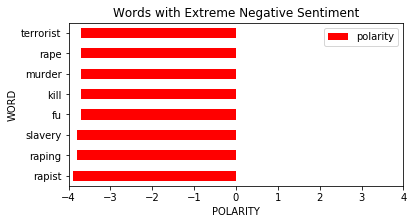

In [4]:
darth_path = "/Users/mathewbuck/Desktop/dighum100/twitter_bot/darth.jpg"
display(Image(darth_path, width=450, unconfined=True))

vader_lex_df = pd.read_csv('vader_lexicon.txt', sep="\t", header=None) 
vader_lex_df.columns = ['word', 'polarity', 'junk', 'trash']
vader_lex_df = vader_lex_df.drop(['junk', 'trash'], axis=1)
#vader_lex_df.iloc[2000 : 2005]
print("VADAR thinks that there are around 7,000 words that can help quantify the sentiment of a sentence.")

vader_lex_df.describe()
extreme_neg = (vader_lex_df[vader_lex_df['polarity']
                .agg(lambda x: (x <= -3.7))]
                .sort_values('polarity')
                .set_index("word"))

extreme_pos = (vader_lex_df[vader_lex_df['polarity']
                .agg(lambda x: (x >= 3.3))]
                .sort_values('polarity')
                .set_index("word"))

fig = extreme_neg.plot.barh(figsize=(6, 3), color = "red")
plt.xlim([-4, 4])
plt.xlabel("POLARITY")
plt.ylabel("WORD")
plt.title("Words with Extreme Negative Sentiment");
print()

fig = extreme_pos.plot.barh(figsize=(6, 3), color = "blue")
plt.xlim([-4, 4])
plt.xlabel("POLARITY")
plt.ylabel("WORD")
plt.title("Words with Extreme Positive Sentiment");
plt.show()


# methods ##################################################################################

analyser = SentimentIntensityAnalyzer()


def sentiment_score(tweet_str):
    """parameter: string representing the text of a single tweet
       return: the sentiment rating of sentence_str"""
    return analyser.polarity_scores(tweet_str)["compound"]
    
    
def mean_sentiment(tweet_text_ser):
    return pd.Series([sentiment_score(tweet_text) for tweet_text in tweet_text_ser]).mean()
    
#dataset_df["sentiment_score"] = dataset_df["tweet_text"].apply(mean_sentiment)
#dataset_df = dataset_df[dataset_df['sentiment_score'].notnull()]
#dataset_df.tail(3)

In [5]:
# This cell saves the DataFrame object I created above to text_df.csv in the project file.
#dataset_df.to_csv("dataset_df.csv", sep=',', encoding='utf-8', index=False)  

In [6]:
# This cell reads in the text_df.csv file I created earlier to speed up processing.
dataset_df_path = "/Users/mathewbuck/Desktop/dighum100/twitter_bot/dataset_df.csv"
dataset_df = pd.read_csv(dataset_df_path)
dataset_df.tail(3)

follower_id  \
194  1025626087307575296   
195  1041349589842878464   
196           2585686880   

                                                                                                                                                                                                                                                                                      tweets  \
194  [Status(_api=<tweepy.api.API object at 0x7fbe94a00be0>, _json={'created_at': 'Tue Jun 16 06:43:39 +0000 2020', 'id': 1272781871064027136, 'id_str': '1272781871064027136', 'text': 'RT @EKOtoons: I WILL FOLLOW\nTHIS WOMAN\nINTO BATTLE\n\nhttps://t.co/w0G0qS7lz5', 'truncated': F...   
195  [Status(_api=<tweepy.api.API object at 0x7fbe94a00be0>, _json={'created_at': 'Thu May 07 12:10:04 +0000 2020', 'id': 1258368502450307072, 'id_str': '1258368502450307072', 'text': '@CombatPhot Iâ€™d love to snag one of your pins! Please DM me details. Thank you!', 'truncated': F...   
196  [Status(_api=<tweepy.api.API object at 0x7fbe94a00be0>, _json={'created_at': 'Sat Jun 20 15:18:52 +0000 2020', 'id': 1274361078194081792, 'id_str': '1274361078194081792', 'text': 'Twitter Tantrum in 3-2-1...\nJudge Rejects Trump Request for Order Blocking Boltonâ€™s Memoir http...   

                                                                                                                                                                                                                                                                                  tweet_text  \
194  ['RT @EKOtoons: I WILL FOLLOW\nTHIS WOMAN\nINTO BATTLE\n\nhttps://t.co/w0G0qS7lz5', '@pulte Thank god for @pulte help a brother out please.', '@pulte Help me out please.', 'RT @pcbrynn: This is the only thing you need to watch today. ðŸ’™ðŸ’™ðŸ’™ https://t.co/j1IA7pJbsf', 'RT @CallMeC...   
195  ['@CombatPhot Iâ€™d love to snag one of your pins! Please DM me details. Thank you!', 'THIS: Has been resounding with me lately. Stay positive, and keep fighting. https://t.co/KxMshTKJ0J', 'RT @HistoricDET: #OTD 98 years ago, the first steel was lifted into place for the @mason...   
196  ['Twitter Tantrum in 3-2-1...\nJudge Rejects Trump Request for Order Blocking Boltonâ€™s Memoir https://t.co/1fENCF1ero', 'Finally watching Derek on Netflix. Damn you @rickygervais! If Iâ€™m not crying from laughter, Iâ€™m crying from kindness.', 'https://t.co/ECeyQkgZBL', '@GovWhi...   

     sentiment_score  
194         0.025485  
195         0.139250  
196        -0.002740

## Conclusions / Statistics

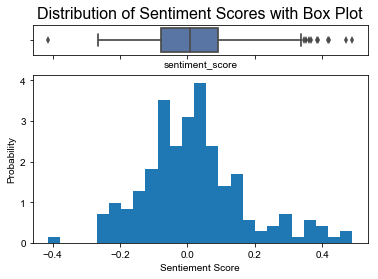

count    197.000000
mean       0.017984
std        0.151877
min       -0.413280
25%       -0.078885
50%        0.006160
75%        0.089355
max        0.488880
Name: sentiment_score, dtype: float64

In [7]:
print()
print()

fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.set(rc={"figure.figsize": (8, 4)}); np.random.seed(0)

# Add a graph in each part
fig = sns.boxplot(dataset_df["sentiment_score"], ax=ax_box)
plt.hist(dataset_df["sentiment_score"], density=True, bins=25)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Sentiement Score');

# Change figure size
fig = sns.set(rc={'figure.figsize':(11.7, 8.27)}) 

# Move title up on y axis
plt.title("Distribution of Sentiment Scores with Box Plot", y=1.3, fontsize = 16);
plt.show()

dataset_df["sentiment_score"].describe()

## The Twitter Bot

In [8]:
####################################################################################################################
# TWITTER-BOT CODE #################################################################################################
# DON'T RUN THE BOT MORE THAN ONCE A DAY TO AVOID SUSPENSIONS !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
####################################################################################################################

# SMART LIST DOESN N0T YIELD MANY NEW FOLLOWERS AT ALL
# users_to_retweet = (["AndrewYang","jimmy_dore", "JimmyDoreShow", "mtaibbi", "EricRWeinstein", "ZachandMattShow", 
#                      "KatTimpf", "RealCandaceO", "thrashermag", "joerogan", "DanCrenshawTX", "RepDanCrenshaw", 
#                      "TulsiGabbard", "hilltvlive", "Krystallball", "kthalps", "esaagar", "Timcast", "CHSommers", 
#                      "SamHarrisOrg", "elonmusk", "Space_Station", "SpaceX", "VanJones68", "PlanetTyrus", 
#                      "HumanityForward", "RussForUs2020", "WilliamShatner"])


# DUMB LIST GETS ABOUT 50-75 SHEEP TO FOLLOW THE BOT EACH DAY BY POSTING (mostly) MAINSTREAM NEWS 
users_to_retweet = (["AndrewYang", "CNNPolitics", "ZachandMattShow", "MSNBC", "cnnbrk", "cnni", 
                     "JoeBiden", "MSN_Money", "MichelleObama", "BernieSanders", "Krystallball", 
                     "kthalps", "esaagar", "BarackObama", "ABC", "NBCNews", "CBSNews", "NBCNews", 
                     "VanJones68", "MSNBC_Breaking", "HumanityForward", "RussForUs2020", "WilliamShatner", 
                     "GeorgeTakei"])


def build_retweet_list(user_list, max_tweets_per_user):
    """user_list: list of user_names 
       max_tweets_per_user: maximum number of retweets that will be posted for any user_name
       return: a list containing 1 or more tweet.id objects for each user_name in user_list """
    # make initial request for most recent tweets (20 is the maximum allowed count)
    tweet_ids_list = []
    for user in users_to_retweet:
        tweets = api.user_timeline(id=user, count=random.randint(1, max_tweets_per_user))
        tweet_ids = [tweet.id for tweet in tweets]
        tweet_ids_list += tweet_ids

    random.shuffle(tweet_ids_list)
    print("Number of tweets that the bot will attempt to post: ", len(tweet_ids_list))
    return tweet_ids_list


def run_twitter_bot(users_to_retweet, max_tweets_per_user, min_seconds, max_seconds):
    """users_to_tetweet: list of twitter user_names associated with the users that the bot will retweet
       max_tweets_per_user: maximum number of retweets that will be posted for any user_name
       min_seconds: minimum time between tweets/follows
       max_seconds: maximum time between tweets/follows
       return: True upon completion"""
    bot_path = "/Users/mathewbuck/Desktop/dighum100/twitter_bot/twitter_bot.png"
    display(Image(bot_path, width=500, unconfined=True))
    num_follows = 0
    num_tweets_made = 0

    for id in build_retweet_list(users_to_retweet, max_tweets_per_user):
        first_100 = api.retweets(id, 100)  # get the first 100 retweets for each tweet 
    
        # only retweet FAIRLY POPULAR posts 
        if len(first_100) > 75:
        
            try:
                api.retweet(id)
                num_tweets_made += 1
                print()
                print("NEW TWEET NUMBER: ", num_tweets_made)
           
            # catch 'You have already retweeted this Tweet.' errors 
            except tweepy.TweepError as e:
                print()
                print(e)
            
            #follow some peeps, some will follow back 
            end_range = random.randint(61, 70)  # HARD CODE, GOAL IS 400 NEW FOLLOWS PER DAY
            potential_followers = first_100[60 : end_range] 
            potential_screen_names = [sheep.user.screen_name for sheep in potential_followers]
        
            if len(potential_screen_names) > 0:
                for screen_name in potential_screen_names:
                    num_seconds = random.randint(min_seconds, max_seconds)  #adjust time period between re-tweets 
                    try:
                        api.create_friendship(screen_name)  # follow some peeps 
                        num_follows += 1
                        print("Number of new follows: ", num_follows)
                        
                    except tweepy.TweepError as e:
                        print(e)
                    
                    print("Minutes until next follow: ", num_seconds / 60)
                    time.sleep(num_seconds)
                    
    return True

    
# RUN THE TWITTER-BOT 
#print(run_twitter_bot(users_to_retweet, max_tweets_per_user=3, min_seconds=17, max_seconds=43))

In [8]:
# DON'T RUN ON THE SAME DAY AS YOU RUN THE BOT OR TWITTER WILL SUSPEND YOU AGAIN!!!!!!!!!!!!!!

def unfollow_users():
    """This method unfollows between 50 and 99 users.  
    The number x and time intervals are chosen randomly to avoid creating detectable patterns.
    return: True"""
    x = random.randint(50, 99)
    last_x_friends = api.friends(count=x)
    last_x_screen_names = [user.screen_name for user in last_x_friends]
    for name in last_x_screen_names:
        try:
            api.destroy_friendship(name)
            num_seconds = random.randint(31, 63)  #adjust time period 
            time.sleep(num_seconds)
        except tweepy.TweepError as e:
            print(e)
    print("Number of users that have been unfollowed:", x)
    return True


for _ in range(0, 3):
    print(unfollow_users())

Number of users that have been unfollowed: 64
True
Number of users that have been unfollowed: 95
True
